<a href="https://colab.research.google.com/github/haein0224/Study_machinelearning/blob/main/%EC%9D%8C%EC%84%B1%EB%B6%84%EB%A5%98%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 음성 분류 경진대회 EDA
필사 자료 : https://dacon.io/competitions/official/235905/codeshare/5138?page=1&dtype=recent


### 1. 분석환경 준비

In [4]:
import librosa
import librosa.display as dsp
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

### 2. CSV 파일 EDA

In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/user_data/train.csv')
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


In [ ]:
train.shape
# 400행 3열

(400, 2)

In [ ]:
print(train.label.unique())
train.label.groupby(train.label).count()
# 각각은 40개씩 균일하게 분포하고 있음

[9 0 1 8 7 4 5 2 6 3]


label
0    40
1    40
2    40
3    40
4    40
5    40
6    40
7    40
8    40
9    40
Name: label, dtype: int64

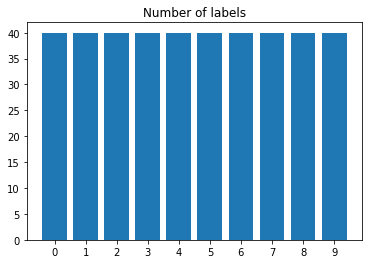

In [ ]:
X = train.label.groupby(train.label).count().index ### ?
Y = train.label.groupby(train.label).count()

plt.bar(X,Y)
plt.xticks(X)
plt.title('Number of labels')
plt.show()

### 3. WAV 파일 EDA

In [ ]:
# 오디오 시각화

# 함수 정의
def get_audio(num=0) :
  # Audio Sample Directory
  sample = os.listdir('/content/drive/MyDrive/Colab Notebooks/user_data/train')
  temp = train[train.label == num].file_name # train csv 파일을 이용해 label과 매치되는 file명을 가져옴
  file_name = temp[temp.index[0]] # 그 중에서 첫번째 데이터를 불러와 듣고자함

  file = '/content/drive/MyDrive/Colab Notebooks/user_data/train/' + file_name

  # Get Audio from the location
  data, sample_rate = librosa.load(file) 
  ## librosa를 이용해 데이터를 load 하면 두가지지 output이 나옴
  ## 1) array 형식으로된 data, 숫자형으로된 sample_rate

  # Plot the audio wave
  dsp.waveshow(data,sr=sample_rate)
  plt.show()

  # Show the widget
  return Audio(data=data, rate=sample_rate)


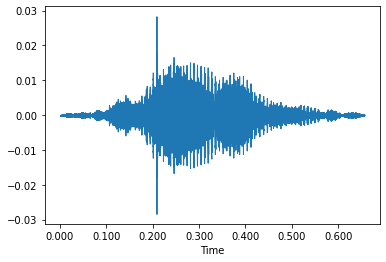

In [ ]:
# 숫자 0 음성
get_audio(0)

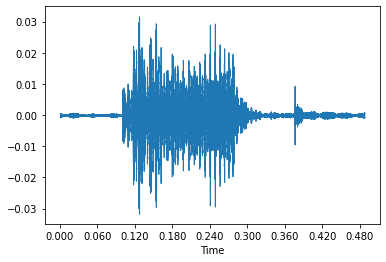

In [ ]:
get_audio(8)

### 4. 퓨리에 변환 (FFT : Fast Fourier Transform)

음성 데이터를 분석하기 위하여 주파수(frequency)를 성분을 뽑아내기 위해 퓨리에 변환(Fourier Transform)을 해야함
(입력 신호를 다양한 주파수를 가지는 주기함수들로 분해하는 것 -> 이를 통해 음성데이터에서 실제제 유용한 소리를 추출)

- 음성이 어느 주파수의 어느정도 magnitude를 가진 주기함수로 구성되어있다는 것은 확인되지만 시간정보가 손싱 되어 음성 합성 및 인식에는 적절하지 않음 => 시간 단위로 짧게 쪼게서 fft를 하는 librosa.sfft도 존재

In [25]:
def fourier_transform(num=0) :
  # Audio Sample Directory
  sample = os.listdir('/content/drive/MyDrive/Colab Notebooks/user_data/train')
  temp = train[train.label == num].file_name
  file_name = temp[temp.index[0]] # 그 중에서 첫번째 데이터를 불러오고자 함

  file = '/content/drive/MyDrive/Colab Notebooks/user_data/train/' + file_name

  # Get Audio from the location
  data, sample_rate = librosa.load(file) # 오디오 파일을 로딩
    
  fft = np.fft.fft(data) # 퓨리에 변환

  magnitude = np.abs(fft)
  frequency = np.linspace(0, sample_rate, len(magnitude)) # np.linspace(start, end, num) 

  left_frequency = frequency[:int(len(frequency)/2)] # 절반 나눠서 왼쪽
  left_magnitude = magnitude[:int(len(magnitude)/2)]

  fig = plt.figure(figsize=(14,5))
  plt.plot(left_frequency, left_magnitude) # 시각화는 left에 대해서만 진행
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title(f'Fourier transform of audio label {num}')
  plt.show() 
            

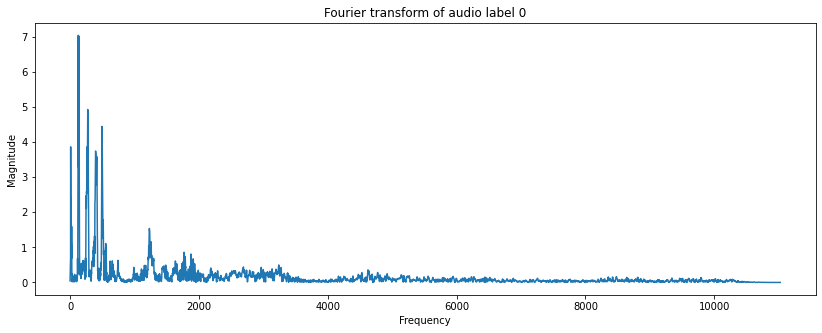

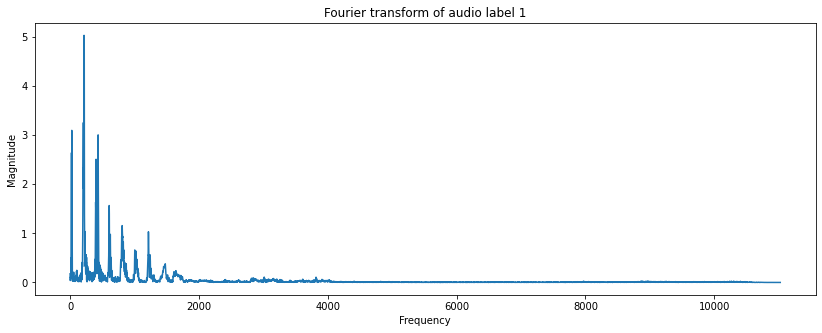

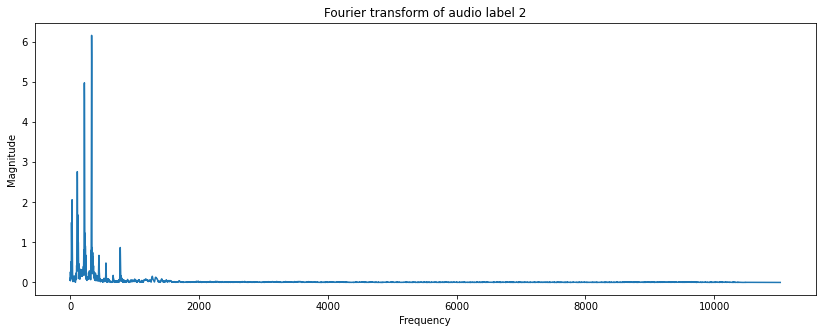

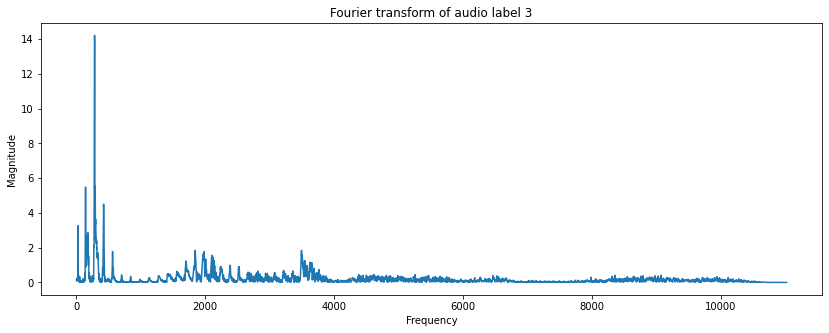

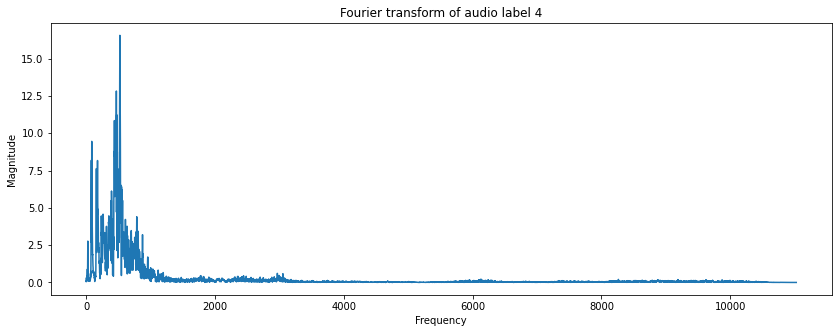

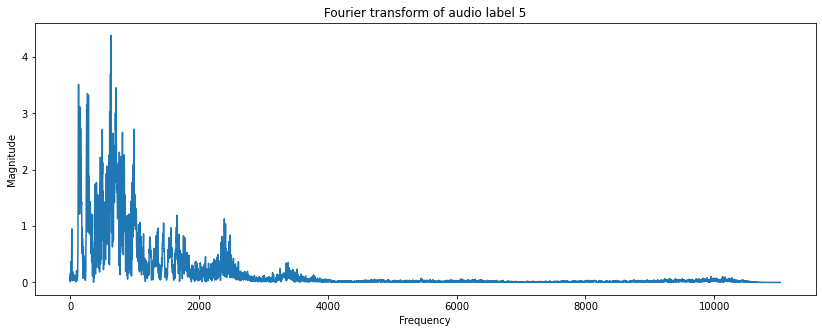

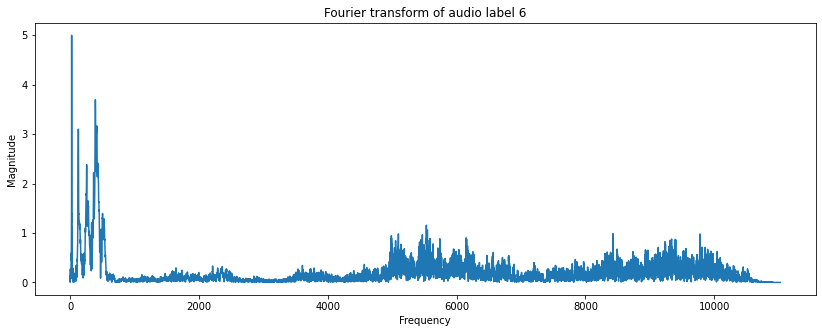

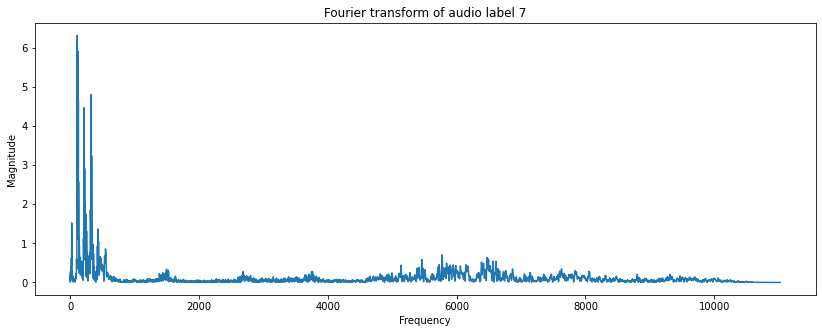

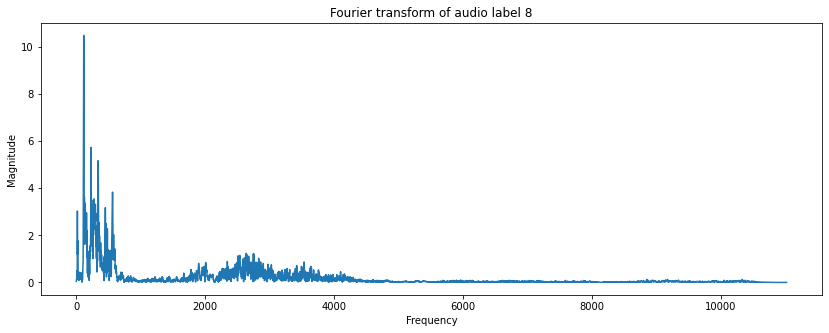

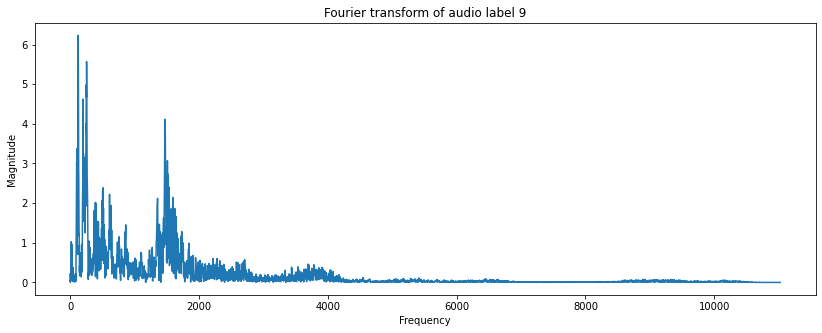

In [26]:
for i in range(0,10) :
  fourier_transform(i)

  # 숫자에 따라 에너지의 분포가 상이함을 확인할 수 있음

## 4. Mel Spectrogram

- Spectogram은 소리나 파동을 시각화하여 파악하기 위한 도구로, 파형(waveform)과 스펙트럼(spectrum)의 특징이 조합되어있음  
- Mel Spectrogram은 주파수를 mel-scale로 변환한 형태로 낮은 주파수를 높은 주파수보다 더 예민하게 받아들임

1. n_fft : 한번 fft를 해 줄 만큼의 sequence 길이 (자연어 처리의 기본 음성 : 25m의 크기 & 사람의 목소리는 16000Hz 이내에 포함 => n_fft = 16000*0.025(frame_length) = 400이 됨)
2. hop_length : window 간의 거리 (sampling rate * frame_stride)
3. win_length : 윈도우 길이 (따로 지정하지 않으면 n_fft가 이 값을 담당)

참고 자료 : https://judy-son.tistory.com/6

In [57]:
def Mel_s(num=0, frame_length = 0.025, frame_stride = 0.010) : # stride : 폭
  
  sample = os.listdir('/content/drive/MyDrive/Colab Notebooks/user_data/train')
  temp = train[train.label == num].file_name
  file_name = temp[temp.index[0]] # 그 중에서 첫번째 데이터를 불러오고자 함

  file = '/content/drive/MyDrive/Colab Notebooks/user_data/train/' + file_name
  data, sample_rate = librosa.load(file, sr = 16000) # sample rate 을 26000으로 지정
  
  # 변환에 필요한 input 계산
  input_nfft = int(round(sample_rate*frame_length))
  input_stride = int(round(sample_rate*frame_stride))

  # 변환
  S = librosa.feature.melspectrogram(y=data, n_mels=100, n_fft=input_nfft, hop_length=input_stride)

  print("Wav length : {}, Mel_S shape : {}".format(len(data)/sample_rate, np.shape(S)))

  S_dB = librosa.power_to_db(S, ref=np.max)
  fig = plt.figure(figsize=(14,5))
  librosa.display.specshow(S_dB,
                            sr = sample_rate,
                            hop_length = input_stride,
                            x_axis = 'time',
                            y_axis = 'log')
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.colorbar(format = '%+2.0f dB')
  plt.title(f"Mel Spectrogram of audio label {num}")
  plt.show()

  


Wav length : 0.6563125, Mel_S shape : (100, 66)


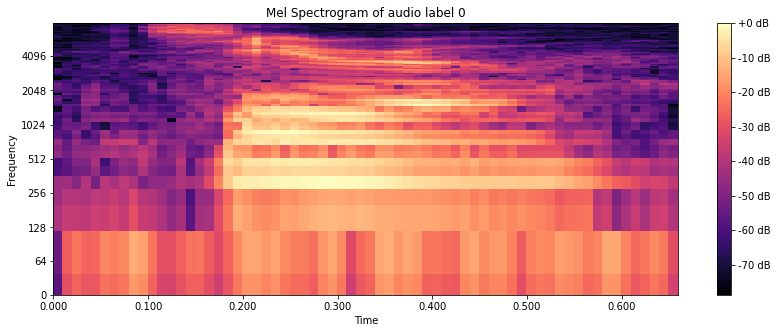

Wav length : 0.6455, Mel_S shape : (100, 65)


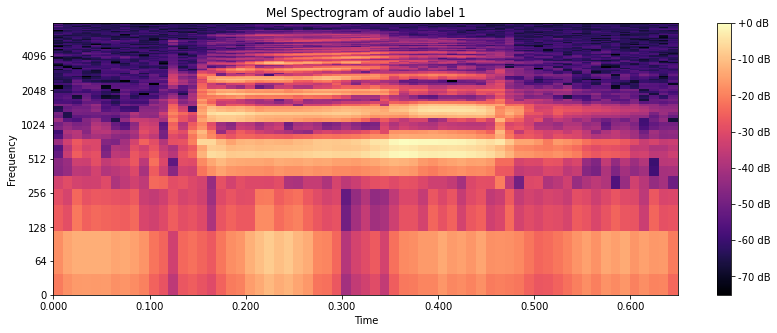

Wav length : 0.544375, Mel_S shape : (100, 55)


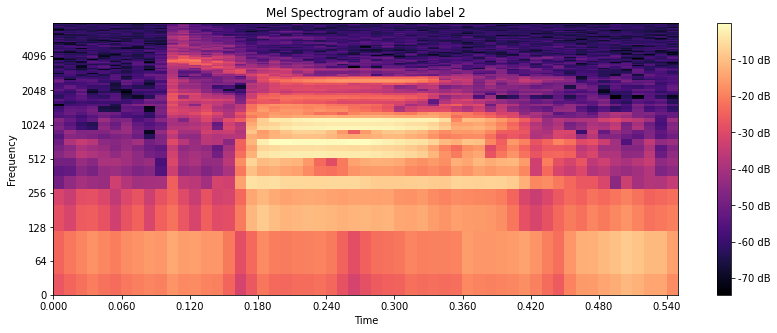

Wav length : 0.661625, Mel_S shape : (100, 67)


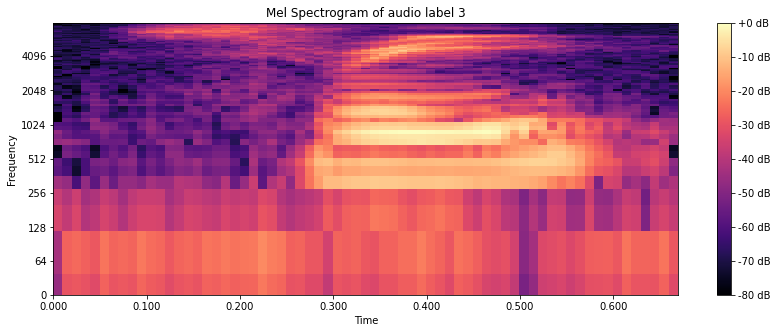

Wav length : 0.6255625, Mel_S shape : (100, 63)


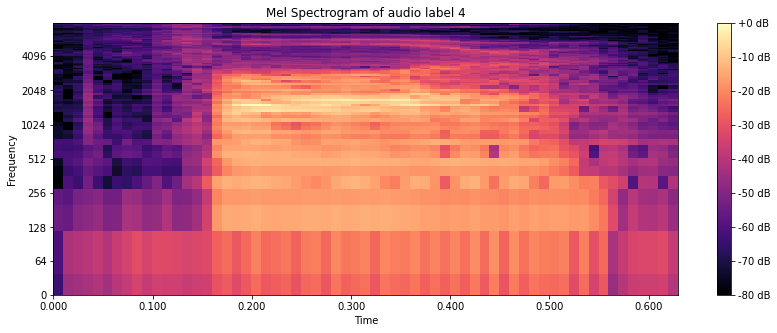

Wav length : 0.540125, Mel_S shape : (100, 55)


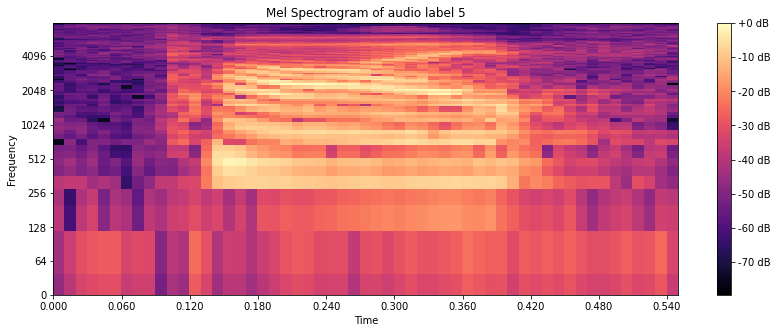

Wav length : 0.7418125, Mel_S shape : (100, 75)


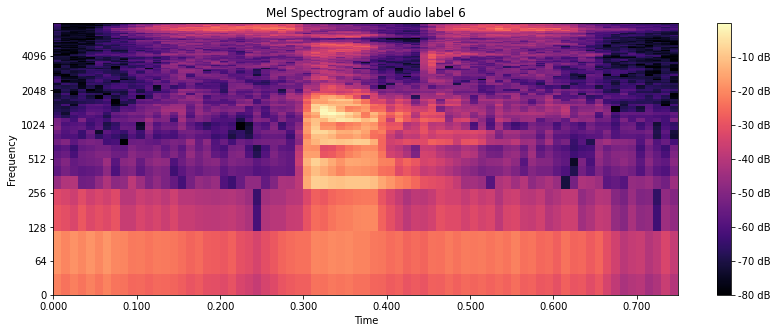

Wav length : 0.707875, Mel_S shape : (100, 71)


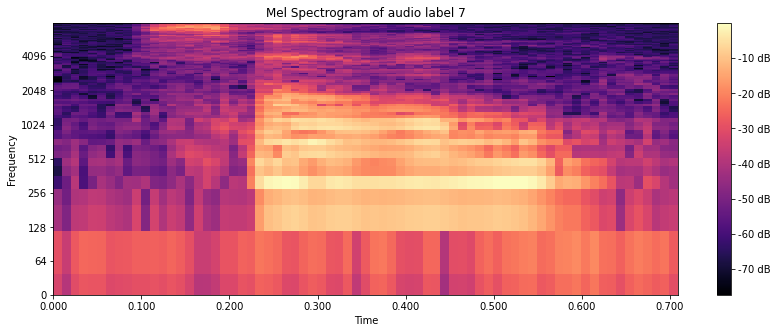

Wav length : 0.487625, Mel_S shape : (100, 49)


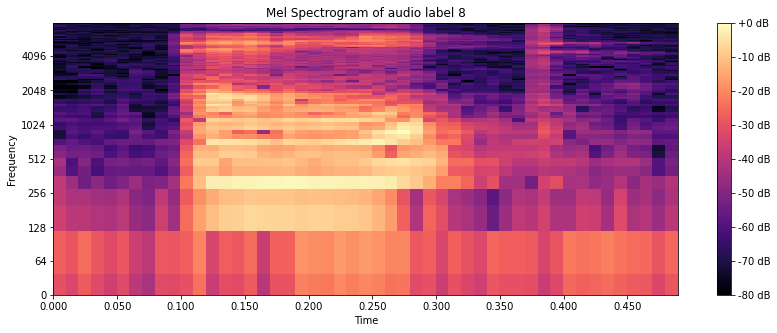

Wav length : 0.637, Mel_S shape : (100, 64)


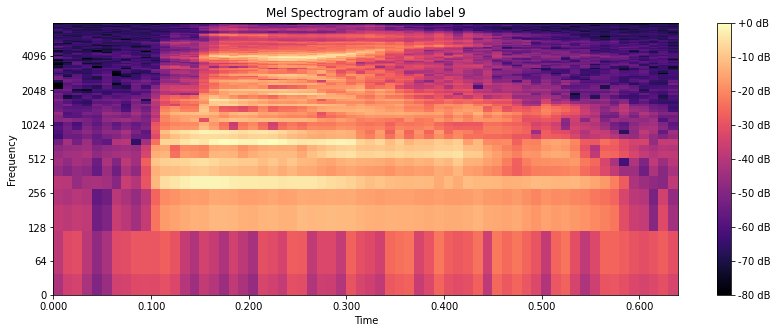

In [58]:
for i in range(0,10) :
  Mel_s(i)